In [1]:
import pandas as pd
import numpy as np
import glob
import gc
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.coordinates import SkyCoord, AltAz, angular_separation
import astropy.units as u
from scipy.stats import binned_statistic
from scipy.signal import lombscargle
import h5py
from astropy.io import fits
from astropy.table import Table

In [2]:
def get_list_of_subruns(df_tot, runID):
    df_tmp=df_tot[df_tot['runID_int']==runID]
    df_tmp=df_tmp.sort_values(by='subRunID_int')
    return df_tmp['subRunlist'].values

In [3]:
df_list=pd.read_csv("subRunlist.csv")

In [4]:
df_list_v09=df_list[df_list['ver']=="v0.9"]
df_list_v10=df_list[df_list['ver']=="v0.10"]

In [5]:
df_list_v09_sorted = df_list_v09.sort_values(by='runID_int')
df_list_v10_sorted = df_list_v10.sort_values(by='runID_int')

In [6]:
v09_runID=np.unique(df_list_v09_sorted['runID_int'].values)
v10_runID=np.unique(df_list_v10_sorted['runID_int'].values)

In [7]:
print(len(v10_runID))
print(len(v09_runID))
print(len(v09_runID) + len(v10_runID))

7118
5975
13093


In [8]:
v_runID=np.unique(np.concatenate((v09_runID,v10_runID)))

In [9]:
print(len(v_runID))

10630


In [10]:
runID_ii = 0
print(get_list_of_subruns(df_list_v09, v09_runID[runID_ii])[-1])

/home/burmist/home2/work/CTA/muons_DL1_tar_gz/20191123/v0.9/muons_LST-1.Run01615.0060.fits


In [11]:
runID_ii = 0
print(v09_runID[runID_ii])
dat09 = [Table.read(get_list_of_subruns(df_list_v09, v09_runID[runID_ii])[i], format='fits').to_pandas() for i in np.arange(0,len(get_list_of_subruns(df_list_v09, v09_runID[runID_ii])))]

1615


In [12]:
runID_ii = 1000
print(v10_runID[runID_ii])
dat10 = [Table.read(get_list_of_subruns(df_list_v10, v10_runID[runID_ii])[i], format='fits').to_pandas() for i in np.arange(0,len(get_list_of_subruns(df_list_v10, v10_runID[runID_ii])))]

10636


In [13]:
df_muons_dat09 = pd.concat(dat09)
df_muons_dat10 = pd.concat(dat10)
df_muons = df_muons_dat10

In [14]:
df_muons['d_time']=df_muons['event_time'].diff()

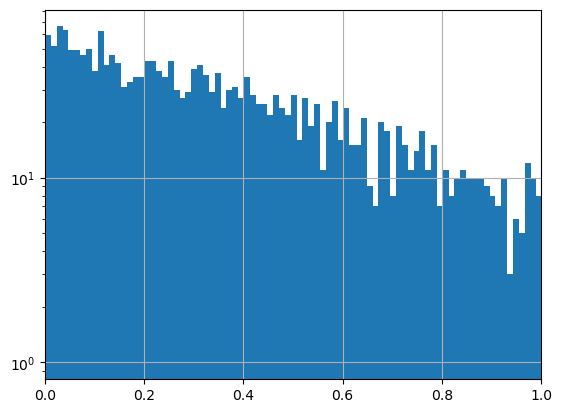

In [15]:
ax = df_muons['d_time'][1:].hist(bins=300)
ax.set_xlim(0,1.0)
ax.set_yscale("log")

<Axes: >

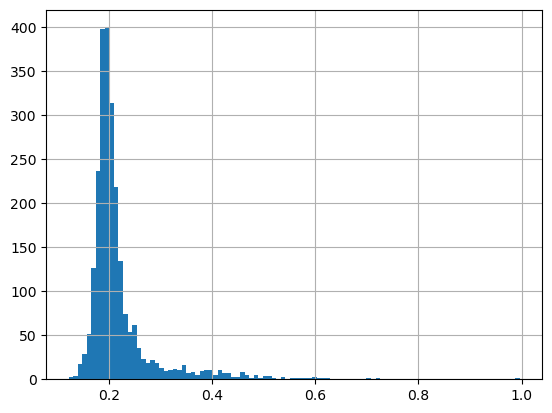

In [16]:
df_muons[df_muons['muon_efficiency']<1.0]['muon_efficiency'].hist(bins=100)

In [17]:
len(df_muons)/(df_muons['event_time'].values[-1] - df_muons['event_time'].values[0])

np.float64(2.123094937523652)

In [18]:
len(df_muons)

2449

In [19]:
df_muons.keys()

Index(['event_id', 'event_time', 'mc_energy', 'ring_size', 'size_outside',
       'ring_center_x', 'ring_center_y', 'ring_radius', 'ring_width',
       'good_ring', 'muon_efficiency', 'ring_containment', 'ring_completeness',
       'impact_parameter', 'impact_x_array', 'impact_y_array', 'radial_stdev',
       'radial_skewness', 'radial_excess_kurtosis', 'num_pixels_in_ring',
       'mean_pixel_charge_around_ring', 'hg_peak_sample', 'lg_peak_sample',
       'd_time'],
      dtype='object')

In [20]:
df_muons

,event_id,event_time,mc_energy,ring_size,size_outside,ring_center_x,ring_center_y,ring_radius,ring_width,good_ring,...,impact_x_array,impact_y_array,radial_stdev,radial_skewness,radial_excess_kurtosis,num_pixels_in_ring,mean_pixel_charge_around_ring,hg_peak_sample,lg_peak_sample,d_time
0,89,1.668660e+09,-1,1832.678345,18.611147,0.109271,-0.500952,0.858011,0.108278,True,...,-0.242120,-4.184291,0.076176,-0.445908,0.579347,255,0.729422,8,0,NaN
1,856,1.668660e+09,-1,1220.209595,0.000000,-2.031785,0.078404,1.017742,0.091953,True,...,7.774688,-4.254791,0.048729,-0.100145,0.245517,188,-0.022650,7,0,0.425626
2,1328,1.668660e+09,-1,2091.079102,0.000000,-1.056340,0.701700,1.136909,0.111295,True,...,8.297882,1.567101,0.081084,-0.514189,0.027532,368,0.432647,7,0,0.260791
3,1793,1.668660e+09,-1,1055.353271,0.000000,-0.510396,-0.861312,0.933421,0.135968,True,...,8.711464,1.761258,0.088349,-0.468060,-0.510149,303,0.303780,8,0,0.274029
4,2495,1.668660e+09,-1,1499.070312,0.000000,-0.332854,-1.261246,0.990636,0.119223,True,...,3.487838,-6.480359,0.054792,0.315547,-0.635547,308,0.600736,5,0,0.411742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,1945329,1.668662e+09,-1,1951.743652,0.000000,-0.063305,0.251985,1.030218,0.106152,True,...,1.954455,-6.037397,0.072547,-0.382636,0.087661,366,0.752997,7,0,1.436297
46,1945586,1.668662e+09,-1,1847.454834,0.000000,-0.699115,0.848707,0.954839,0.106548,True,...,5.066190,3.105755,0.066137,0.003987,0.216354,317,0.491192,8,0,0.161873
47,1946325,1.668662e+09,-1,1467.397461,25.055305,-0.248157,1.505968,1.191193,0.211792,True,...,-3.963535,2.616350,0.066240,0.224025,-0.192669,384,0.745042,7,0,0.428415
48,1947752,1.668662e+09,-1,1103.733398,138.107925,-0.884683,-0.544133,1.098444,0.203781,True,...,4.526197,-4.410679,0.087623,-0.221268,0.708179,420,2.325083,6,0,0.857975


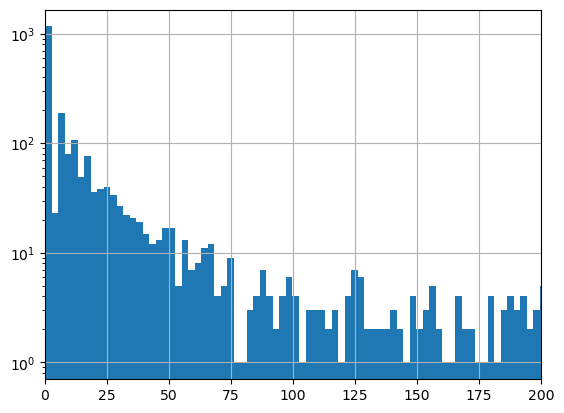

In [21]:
ax = df_muons['size_outside'].hist(bins=400)
ax.set_xlim(0,200)
ax.set_yscale("log")

(0.1, 0.3)

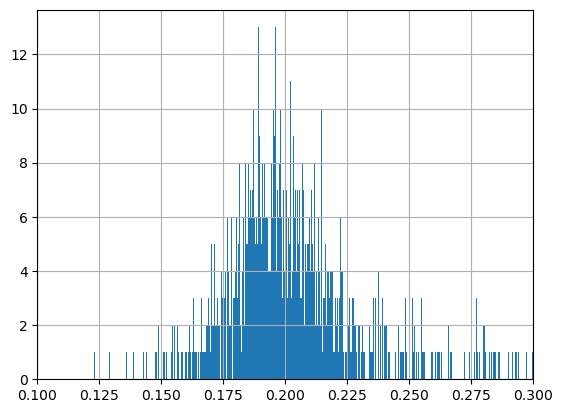

In [22]:
ax = df_muons['muon_efficiency'].hist(bins=10000)
ax.set_xlim(0.1,0.3)
#ax.set_yscale("log")

(0.0, 0.2)

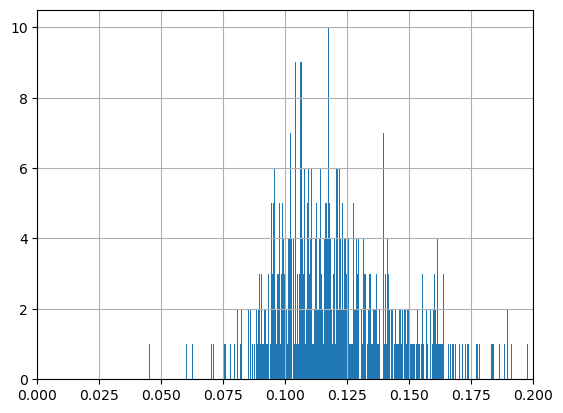

In [23]:
ax = df_muons['ring_width'].hist(bins=10000)
ax.set_xlim(0.0,0.2)
#ax.set_yscale("log")

(-1.0, 2.0)

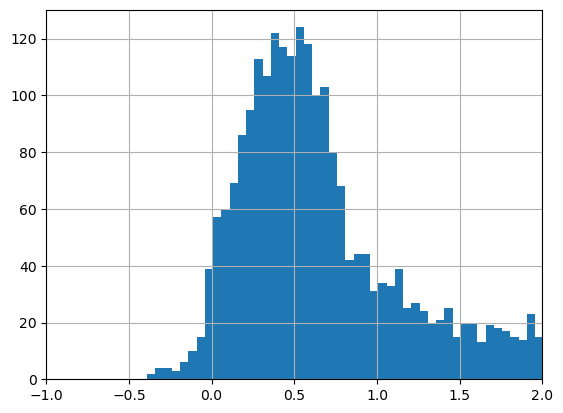

In [24]:
ax = df_muons['mean_pixel_charge_around_ring'].hist(bins=100)
ax.set_xlim(-1.0,2)
#ax.set_yscale("log")

In [25]:
#ax = df_muons[''].hist(bins=100)
#ax.set_xlim(-1.0,2)
#ax.set_yscale("log")

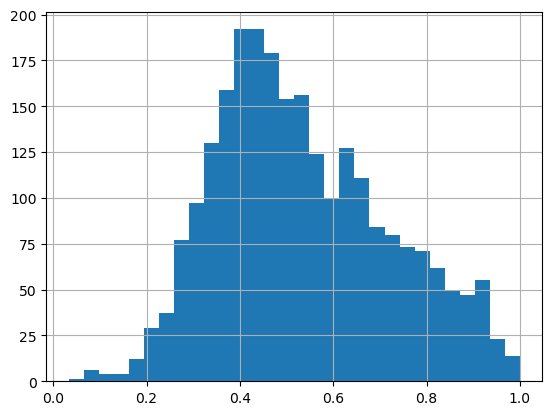

In [26]:
ax=df_muons['ring_completeness'].hist(bins=30)
#ax.set_xlim(1,10)
#ax.set_yscale("log")

(0.75, 1.3)

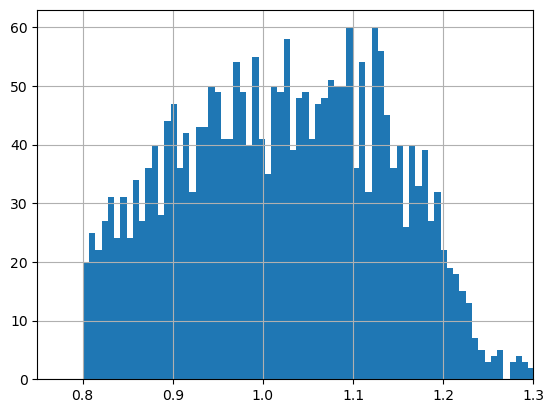

In [27]:
ax=df_muons['ring_radius'].hist(bins=100)
ax.set_xlim(0.75,1.3)
#ax.set_yscale("log")

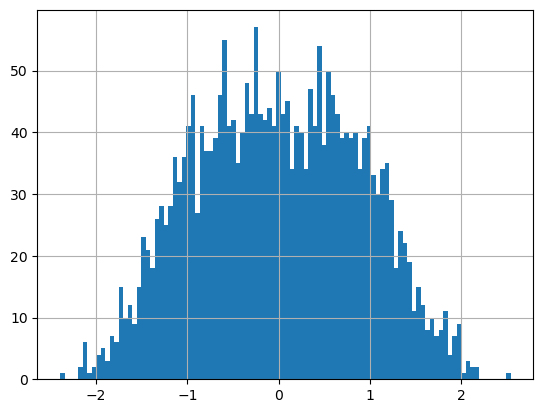

In [28]:
ax = df_muons['ring_center_x'].hist(bins=100)
#ax.set_xlim(0,200)
#ax.set_yscale("log")

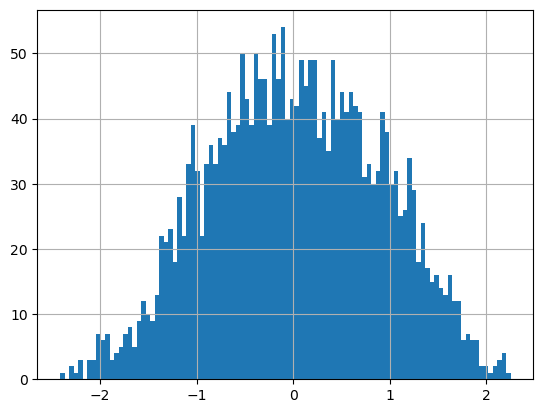

In [29]:
ax = df_muons['ring_center_y'].hist(bins=100)
#ax.set_xlim(0,200)
#ax.set_yscale("log")

In [30]:
#ax = df_muons['x'].hist(bins=100)
#ax.set_xlim(0,200)
#ax.set_yscale("log")

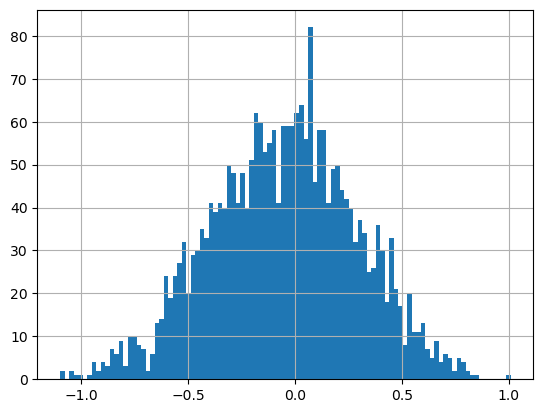

In [31]:
ax = df_muons['radial_skewness'].hist(bins=100)
#ax.set_xlim(0,200)
#ax.set_yscale("log")

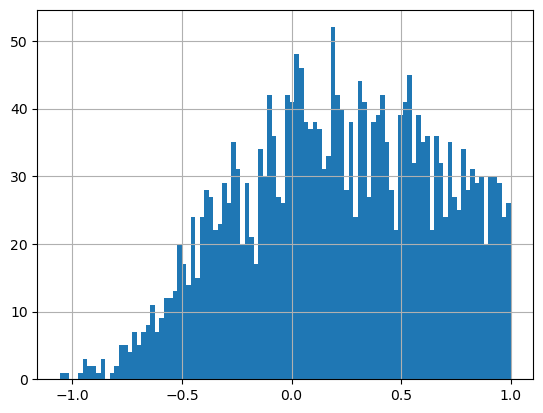

In [32]:
ax = df_muons['radial_excess_kurtosis'].hist(bins=100)

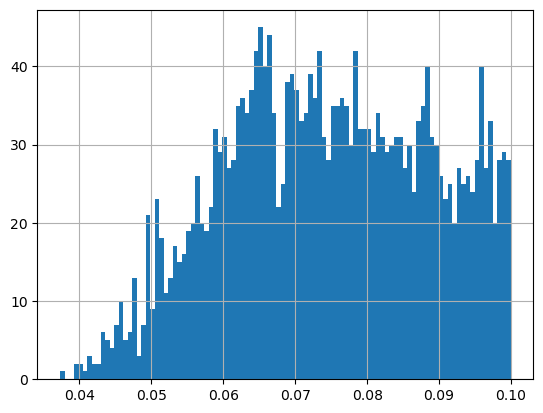

In [33]:
ax = df_muons['radial_stdev'].hist(bins=100)
#ax.set_xlim(0,200)
#ax.set_yscale("log")

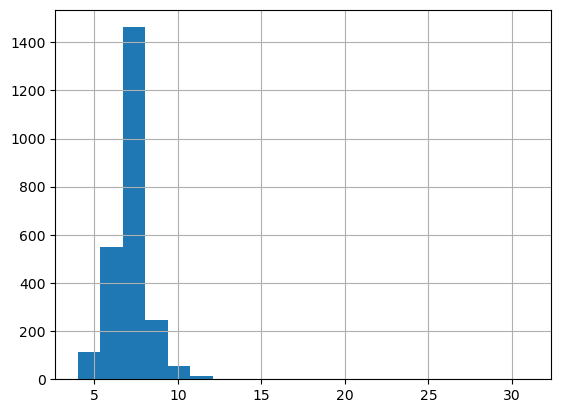

In [34]:
ax = df_muons['hg_peak_sample'].hist(bins=20)
#ax.set_xlim(0,200)
#ax.set_yscale("log")

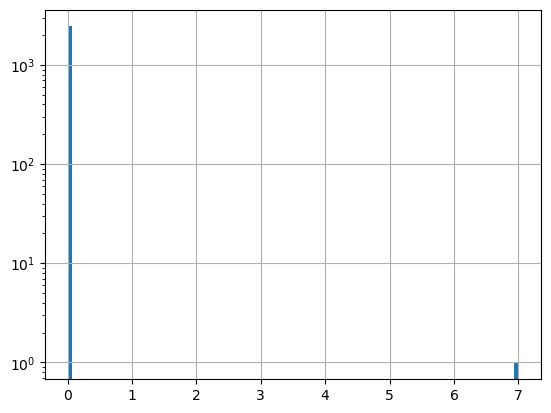

In [35]:
ax = df_muons['lg_peak_sample'].hist(bins=100)
#ax.set_xlim(0,0.1)
ax.set_yscale("log")

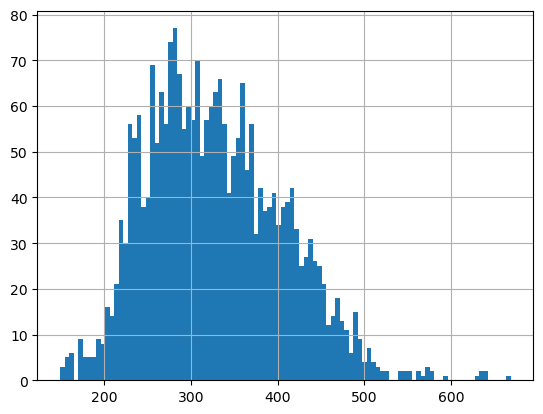

In [36]:
ax = df_muons['num_pixels_in_ring'].hist(bins=100)
#ax.set_xlim(0,0.1)
#ax.set_yscale("log")

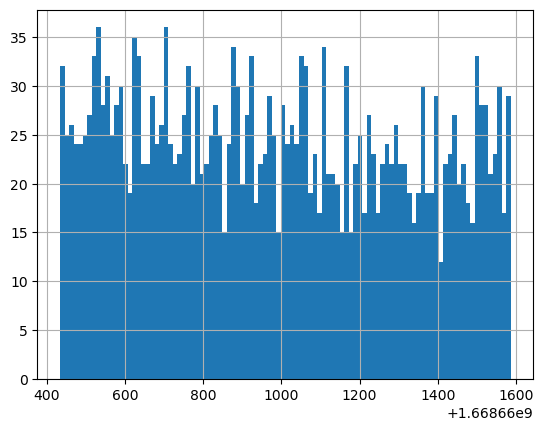

In [37]:
ax = df_muons['event_time'].hist(bins=100)
#ax.set_xlim(0,0.1)
#ax.set_yscale("log")

In [38]:
len(df_muons)/(df_muons['event_time'].values[-1] - df_muons['event_time'].values[0])

np.float64(2.123094937523652)

In [39]:
len(df_muons)

2449

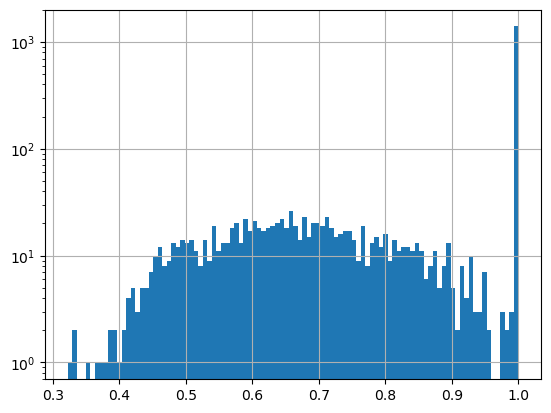

In [40]:
ax = df_muons['ring_containment'].hist(bins=100)
ax.set_yscale("log")

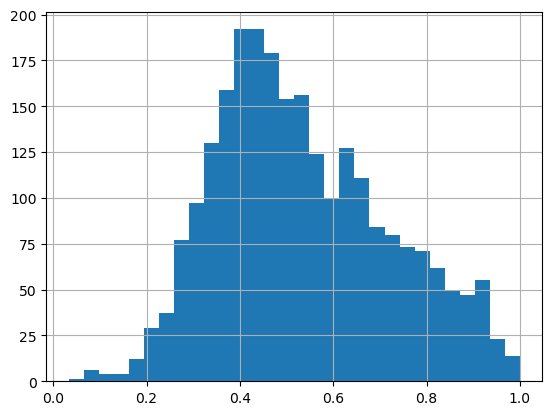

In [41]:
ax = df_muons['ring_completeness'].hist(bins=30)
#ax.set_yscale("log")

<Axes: >

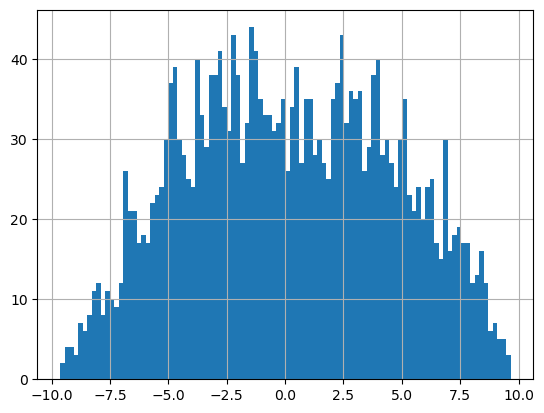

In [42]:
df_muons['impact_x_array'].hist(bins=100)

<Axes: >

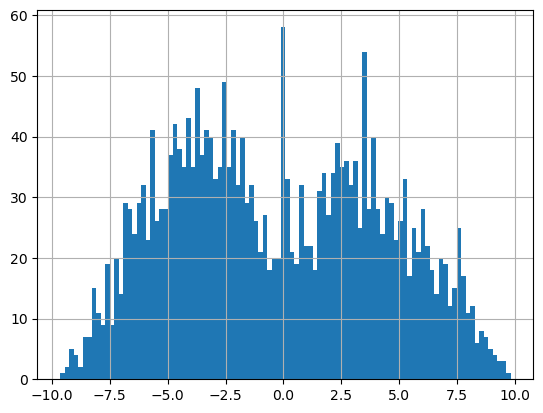

In [43]:
df_muons['impact_y_array'].hist(bins=100)

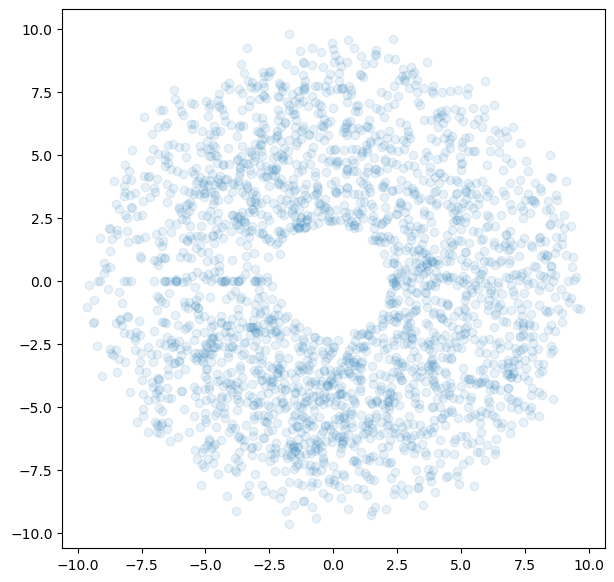

In [44]:
plt.figure(figsize=(7,7))
plt.scatter(df_muons['impact_x_array'].values,df_muons['impact_y_array'].values,alpha=0.1)

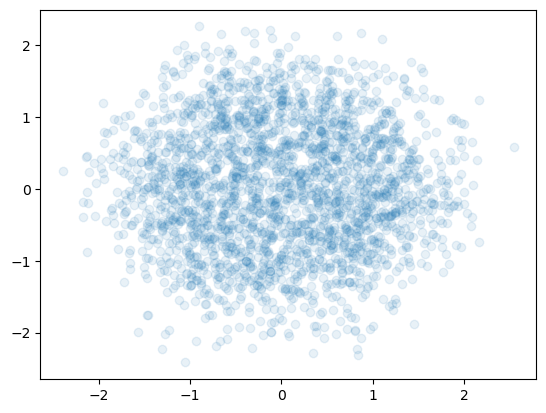

In [45]:
plt.scatter(df_muons['ring_center_x'].values,df_muons['ring_center_y'].values,alpha=0.1)

In [46]:
df_muons['ring_center_r2']=df_muons['ring_center_x']*df_muons['ring_center_x']+df_muons['ring_center_y']*df_muons['ring_center_y']

In [47]:
df_muons['ring_center_r']=np.sqrt(df_muons['ring_center_r2'])

<Axes: >

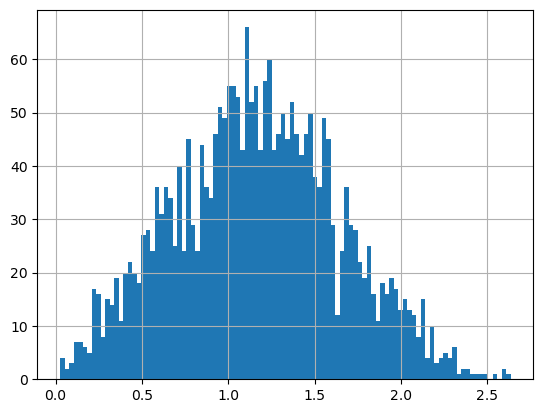

In [48]:
df_muons['ring_center_r'].hist(bins=100)

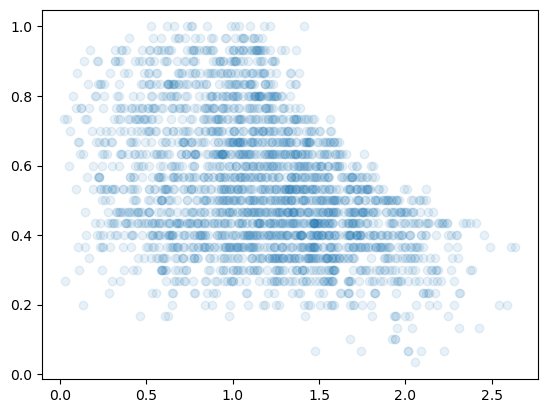

In [49]:
plt.scatter(df_muons['ring_center_r'].values,df_muons['ring_completeness'].values,alpha=0.1)

In [50]:
df_muons['impact_r2_array']=df_muons['impact_x_array']*df_muons['impact_x_array']+df_muons['impact_y_array']*df_muons['impact_y_array']

In [51]:
df_muons['impact_r_array']=np.sqrt(df_muons['impact_r2_array'])

<Axes: >

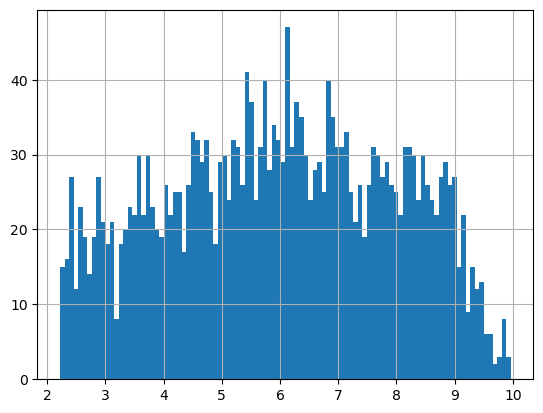

In [52]:
df_muons['impact_r_array'].hist(bins=100)

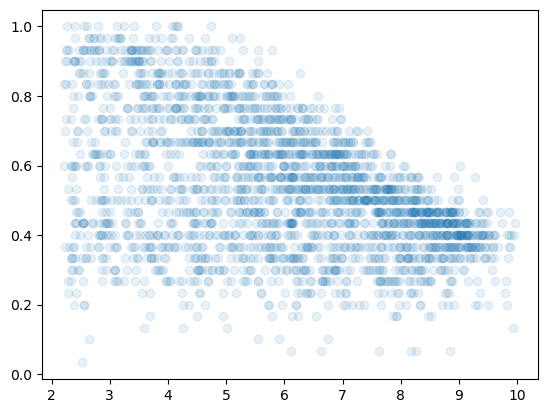

In [53]:
plt.scatter(df_muons['impact_r_array'].values,df_muons['ring_completeness'].values,alpha=0.1)

In [54]:
df_short=df_muons[['impact_r_array','ring_center_r','ring_completeness']]

In [55]:
len(df_short)

2449

In [56]:
df_short.to_csv('test_v0.10.csv',sep=' ')